# News Collection

In [ ]:
from pynytimes import NYTAPI
import datetime
import pandas as pd
import numpy as np

def get_news(year, month, day):
    """
    get top 10 most relevant finance news headings on each day from NY Times
    """
    try:
        # Initialize the NYTAPI object
        # nyt = NYTAPI("FMWU5sNkUErTLUf8zjHM2hWr9MkWbmlT", parse_dates=True)
        nyt = NYTAPI("zWyggCXFeOgLZgZj5evSUfxj8eYWb6mE", parse_dates=True)
        list = []
        
        print(f"Fetching news for {year}-{month}-{day}...")

        # Fetch articles from the API
        articles = nyt.article_search(
            results=10,
            dates={
                "begin": datetime.datetime(year, month, day),
                "end": datetime.datetime(year, month, day)
            },
            options={
                "sort": "relevance",
                "news_desk": [
                    "Business", "Business Day", "Entrepreneurs", "Financial", "Technology"
                ],
                "section_name": [
                    "Business", "Business Day", "Technology"
                ]
            }
        )

        # Check if articles are fetched successfully
        if not articles:
            print(f"No articles found for {year}-{month}-{day}.")
        
        for i in range(len(articles)):
            # Extract the abstract and remove commas
            abstract = articles[i].get('abstract', 'No Abstract Available')
            list.append(abstract.replace(',', ""))
        
        return list
    except Exception as e:
        print(f"Error occurred while fetching news for {year}-{month}-{day}: {e}")
        return []

df = pd.DataFrame()

def generate_news_file():
    """
    Store news headings for each day in a given date range and save to a CSV file
    """
    try:
        start = '2024-03-27'
        end = '2025-03-27'
        
        print(f"Generating news file from {start} to {end}...")

        # Generate a list of dates
        mydates = pd.date_range(start, end)
        dates = [mydates[i].strftime("%Y-%m-%d") for i in range(len(mydates))]

        # Initialize a matrix to store the data
        matrix = np.zeros((len(dates) + 1, 11), dtype=object)
        matrix[0, 0] = "Date"

        # Set column headers for the news
        for i in range(10):
            matrix[0, i + 1] = f"News {i + 1}"

        # Loop through each date and fetch news
        for i in range(len(dates)):
            matrix[i + 1, 0] = dates[i]
            y, m, d = dates[i].split("-")
            print(f"Fetching news for {dates[i]}...")
            news_list = get_news(int(y), int(m), int(d))
            
            if news_list:
                for j in range(len(news_list)):
                    matrix[i + 1, j + 1] = news_list[j]
            else:
                print(f"No news found for {dates[i]}. Filling with empty values.")
                for j in range(10):
                    matrix[i + 1, j + 1] = "No News"
        
        # Convert matrix to DataFrame
        df = pd.DataFrame(matrix)

        # Save to CSV
        df.to_csv("news1.csv", index=False)
        print("News file generated and saved as news.csv")
    except Exception as e:
        print(f"Error occurred while generating the news file: {e}")

# Start the news file generation
generate_news_file()

# 2 stock data collection

In [ ]:
import pandas as pd

def download_stock_data(ticker, start, end):
    """
    download stock price data from Yahoo Finance
    """
    import yfinance as yf
    stock_data = yf.download(ticker, start, end , auto_adjust=False)
    df = pd.DataFrame(stock_data)
    df.to_csv("stock_price1.csv")


download_stock_data("NDX", "2024-03-27", "2025-03-27")

# 3 data cleaning

In [ ]:
import pandas as pd 
import numpy as np

news_df = pd.read_csv("research/stock/news.csv")
stock_df = pd.read_csv("research/stock/stock_price.csv")

for i in range(len(stock_df)):
    date = stock_df['Date'][i][:10]
    stock_df['Date'][i] = date

news_df = news_df[news_df['Date'].isin(stock_df['Date'].tolist())]

news_df.to_csv("news_data.csv", index=False)

# 4 sentiment analysis

In [ ]:
import pandas as pd 

def FinBERT_sentiment_score(heading):
    """
    compute sentiment score using pretrained FinBERT on -1 to 1 scale. -1 being negative and 1 being positive
    """
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    from transformers import pipeline
    tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
    finbert = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
    result = nlp(heading)
    if result[0]['label'] == "positive":
        return result[0]['score']
    elif result[0]['label'] == "neutral":
        return 0
    else:
        return (0 - result[0]['score'])


def VADER_sentiment_score(heading):
    """
    compute sentiment score using pretrained VADER on -1 to 1 scale. -1 being negative and 1 being positive
    """
    import nltk
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    result = analyzer.polarity_scores(heading)
    if result['pos'] == max(result['neg'], result['neu'], result['pos']):
        return result['pos']
    if result['neg'] == max(result['neg'], result['neu'], result['pos']):
        return (0 - result['neg'])
    else:
        return 0

news_df = pd.read_csv("news_data.csv")



BERT_sentiment = []


for i in range(len(news_df)):
    news_list = news_df.iloc[i, 1:].tolist()
    news_list = [i for i in news_list if i != '0']
    score_BERT = FinBERT_sentiment_score(news_list)
    BERT_sentiment.append(score_BERT)


# print(news_df.iloc[129])

news_df['FinBERT score'] = BERT_sentiment

news_df.to_csv("sentiment.csv")

# 5 MLP Model

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf

# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 100
learning_rate = 0.01



# loading stock price data
stock_data = pd.read_csv("stock_price1.csv")
column = ['Close']


len_stock_data = stock_data.shape[0]


# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)


#creating MLP model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            # tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units = 50, activation = "relu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(units = 30, activation = "relu"),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.Dense(units = 20, activation = "relu"),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss = tf.keras.losses.MeanSquaredError,
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    )


    model.fit(
        X_train, y_train,
        epochs = epochs,
    )
    return model


# inverting normaliztion
y_test = scaler.inverse_transform(y_test)



# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    # Reshape predictions to match the expected 2D shape for inverse_transform
    predictions = predictions.reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    return predictions


# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)


# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    return (total_mae / n), (total_mape / n), (total_acc / n), predictions.tolist()


mae, mape, acc, preds = run_model(1)    

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1775
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0270
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0273
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0181
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138
Epoch 16/100
7/7 ━━

ValueError: Found input variables with inconsistent numbers of samples: [270, 27]

In [ ]:
mlp_preds = preds

# 6 Lstm Model

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf

# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 100
learning_rate = 0.02



# loading stock price data
stock_data = pd.read_csv("stock_price1.csv")
column = ['Close']


len_stock_data = stock_data.shape[0]


# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)


#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )


    model.fit(
        X_train, y_train,
        epochs = epochs
    )
    return model

# inverting normaliztion
y_test = scaler.inverse_transform(y_test)



# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions


# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)


# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    model.save("lstm_model.h5")
    return (total_mae / n), (total_mape / n), (total_acc / n), predictions.tolist()


mae, mape, acc, preds = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

# 7 Lstm + Bert

In [30]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf

# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 100
learning_rate = 0.02



# loading stock price and news data
stock_data = pd.read_csv("stock_price1.csv")
news_data = pd.read_csv("sentiment1.csv")
stock_column = ['Close']
news_column = ['FinBERT score']


len_stock_data = stock_data.shape[0]


# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(stock_column).values[:train_examples]
train_sentiment = news_data.get(news_column).values[:train_examples]
test = stock_data.get(stock_column).values[train_examples:]
test_sentiment = news_data.get(news_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]
len_train_sentiment = train_sentiment.shape[0]
len_test_sentiment = test_sentiment.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
len_X_train = len(X_train)
y_train = np.array(train[sequence_length:]).astype(float)


# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
len_X_test = len(X_test)
y_test = np.array(test[sequence_length:]).astype(float)


# adding news sentiment to train and test
for i in range(len_X_train):
    X_train[i] = X_train[i].tolist()
    X_train[i].append(train_sentiment[sequence_length + i].tolist())
X_train = np.array(X_train).astype(float)

for i in range(len_X_test):
    X_test[i] = X_test[i].tolist()
    X_test[i].append(test_sentiment[sequence_length + i].tolist())
X_test = np.array(X_test).astype(float)


#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 70, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 10, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    model.fit(
        X_train, y_train,
        epochs = epochs
    )
    return model


# inverting normaliztion
y_test = scaler.inverse_transform(y_test)



# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions




# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)


# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    return (total_mae / n), (total_mape / n), (total_acc / n) , model


mae, mape, acc , bertmodel = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

In [28]:
# bertmodel.save("bertmodel.keras")
# Save predictions from bert model to use for comparison
bert_predictions = predict(bertmodel)
print(f"Predictions saved for comparison")

# Convert predictions to list for easier handling in visualization
bert_predictions_list = bert_predictions.tolist()

# Create a new dataframe to store all predictions for easier comparison
# comparison_df = pd.DataFrame({
#     'Date': stock_data['Date'][train_examples + sequence_length:],
#     'Actual': stock_data['Close'][train_examples + sequence_length:].values,
#     'MLP': np.array(mlp_preds).flatten(),
#     'LSTM': np.array(lstm_preds).flatten(),
#     'FinBERT-LSTM': np.array(bert_predictions_list).flatten()
# })

# # Save comparisons to CSV
# comparison_df.to_csv("model_predictions_comparison.csv", index=False)

# Fix the model saving issue by recreating with proper loss function
# Instead of using the class directly, use the loss function instance
fixed_model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(units=70, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(units=30, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(units=10, activation="tanh", return_sequences=False),
        tf.keras.layers.Dense(units=1, activation="linear")
    ]
)

fixed_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

# Copy weights from the original model
fixed_model.set_weights(bertmodel.get_weights())

# Save the fixed model
fixed_model.save("bertmodel.keras")
print("Model saved successfully")

In [29]:
#load model
model = tf.keras.models.load_model("bertmodel.keras")

# Analysis

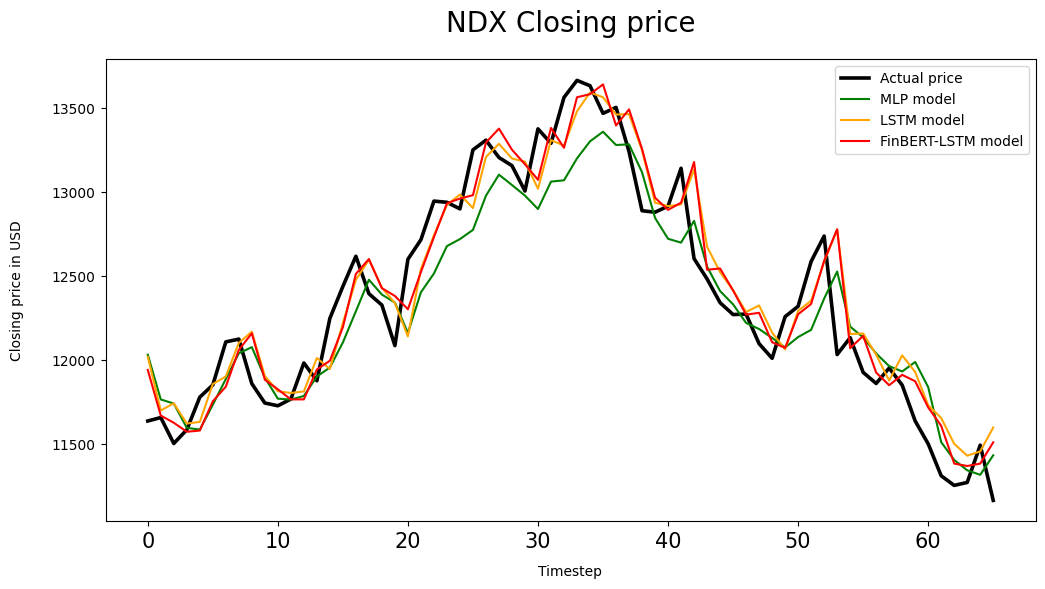

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# mlp

MAE = 218.3297347449103
MAPE = 0.017672041228430347
ACC = 0.9823279587715705

# lstm

MAE = 180.5808388671875
MAPE = 0.014568111768297583
ACC = 0.9854318882317031

# bert

MAE = 174.94284259588053
MAPE = 0.01409574846505943
ACC = 0.9859042515349414


test = [[11637.76953125], [11658.259765625002], [11503.7197265625], [11585.6796875], [11779.900390625], [11852.58984375], [12109.0498046875], [12125.6904296875], [11860.2802734375], [11744.990234375], [11728.5302734375], [11768.400390625], [11983.6201171875], [11877.5], [12249.419921875], [12439.679687499998], [12619.41015625], [12396.4697265625], [12328.41015625], [12086.900390625002], [12601.4697265625], [12717.8701171875], [12947.9697265625], [12940.780273437498], [12901.599609374998], [13253.259765625], [13311.0400390625], [13207.6904296875], [13159.160156250002], [13008.169921875], [13378.320312499998], [13291.990234375], [13565.870117187502], [13667.1796875], [13635.2099609375], [13470.8603515625], [13505.990234374998], [13242.900390625], [12890.5400390625], [12881.7900390625], [12917.8603515625], [13143.580078125], [12605.169921874998], [12484.3203125], [12342.700195312498], [12272.0302734375], [12274.6201171875], [12098.4404296875], [12011.309570312498], [12259.389648437498], [12321.1904296875], [12588.2900390625], [12739.7197265625], [12033.6201171875], [12134.400390625], [11927.490234375], [11861.3798828125], [11953.26953125], [11851.540039062498], [11637.790039062498], [11501.650390625], [11311.240234375], [11254.1103515625], [11271.75], [11493.830078125], [11164.7802734375]]
mlp_preds = [[12033.1279296875], [11766.0888671875], [11741.748046875], [11597.2783203125], [11586.427734375], [11734.6591796875], [11887.9921875], [12041.5537109375], [12077.7578125], [11896.2705078125], [11770.853515625], [11765.4873046875], [11786.8642578125], [11902.90625], [11956.4501953125], [12105.5927734375], [12291.4970703125], [12479.2890625], [12391.0126953125], [12343.361328125], [12162.4912109375], [12404.572265625], [12516.6416015625], [12679.919921875], [12721.6904296875], [12776.34375], [12980.236328125], [13105.5419921875], [13043.7705078125], [12980.7021484375], [12900.7490234375], [13064.083984375], [13071.966796875], [13202.583984375], [13303.8828125], [13361.330078125], [13282.3173828125], [13285.9072265625], [13119.685546875], [12847.8486328125], [12723.44921875], [12700.5205078125], [12830.216796875], [12557.4013671875], [12411.8818359375], [12332.7666015625], [12221.921875], [12185.8388671875], [12132.8984375], [12075.6650390625], [12138.0205078125], [12180.927734375], [12367.0517578125], [12528.2939453125], [12200.2158203125], [12135.8291015625], [12039.96875], [11964.73046875], [11932.828125], [11989.4072265625], [11839.5205078125], [11511.8037109375], [11405.802734375], [11344.064453125], [11317.1650390625], [11433.3408203125]]
lstm_preds = [[12020.5751953125], [11700.19921875], [11743.3896484375], [11622.80078125], [11632.3603515625], [11857.8837890625], [11903.22265625], [12102.81640625], [12169.8837890625], [11905.791015625], [11815.0458984375], [11804.8408203125], [11813.935546875], [12012.810546875], [11947.5693359375], [12221.23828125], [12478.505859375], [12599.0556640625], [12432.064453125], [12339.8955078125], [12141.837890625], [12542.6142578125], [12744.08984375], [12925.4462890625], [12986.8671875], [12906.8583984375], [13210.814453125], [13289.251953125], [13201.775390625], [13182.912109375], [13021.474609375], [13311.38671875], [13278.634765625], [13483.685546875], [13595.1435546875], [13566.681640625], [13463.7373046875], [13466.3662109375], [13251.140625], [12938.515625], [12918.1796875], [12927.7421875], [13136.3984375], [12676.69140625], [12524.7587890625], [12417.150390625], [12286.9755859375], [12326.3251953125], [12164.4208984375], [12064.3134765625], [12294.328125], [12354.201171875], [12586.6357421875], [12777.921875], [12156.05859375], [12159.1962890625], [12032.298828125], [11878.6025390625], [12029.025390625], [11929.7578125], [11732.103515625], [11655.57421875], [11501.6591796875], [11431.138671875], [11456.837890625], [11598.9140625]]
bert_preds = [[11942.0673828125], [11670.080078125], [11627.3056640625], [11573.734375], [11580.79296875], [11755.21875], [11842.345703125], [12061.2412109375], [12160.056640625], [11883.845703125], [11826.6240234375], [11766.48828125], [11766.46875], [11944.3193359375], [11996.85546875], [12196.4736328125], [12514.232421875], [12602.5361328125], [12429.13671875], [12382.8515625], [12303.7119140625], [12525.7041015625], [12733.2841796875], [12934.8603515625], [12963.0615234375], [12983.296875], [13296.8876953125], [13379.7919921875], [13254.068359375], [13167.453125], [13074.763671875], [13383.8681640625], [13265.5693359375], [13566.689453125], [13584.9033203125], [13643.236328125], [13398.4423828125], [13494.5595703125], [13258.59765625], [12968.11328125], [12895.64453125], [12938.5888671875], [13181.1455078125], [12538.9892578125], [12546.5263671875], [12415.6865234375], [12271.3759765625], [12282.298828125], [12107.3251953125], [12073.3056640625], [12273.509765625], [12335.1884765625], [12592.3359375], [12780.23828125], [12071.669921875], [12144.892578125], [11926.337890625], [11851.0947265625], [11912.8154296875], [11874.66796875], [11718.4609375], [11609.2275390625], [11384.0810546875], [11369.7421875], [11383.8935546875], [11510.8017578125]]


plt.figure(figsize=(12, 6))

plt.plot(test, linewidth = 2.6, color = "black")
plt.plot(mlp_preds, color = "green")
plt.plot(lstm_preds, color = "orange")
plt.plot(bert_preds, color = "red")

plt.xlabel("Timestep", fontsize = 10, labelpad = 10)
plt.xticks(fontsize = 15)
plt.ylabel("Closing price in USD", fontsize = 10, labelpad = 20)
plt.title("NDX Closing price", fontsize = 20, pad = 20)
plt.legend(['Actual price', 'MLP model', 'LSTM model', 'FinBERT-LSTM model'], loc='upper right')

plt.show()

Loading models...
Loading data...
Making LSTM predictions...


C:\Users\harsh\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Making FinBERT-LSTM predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step

FinBERT-LSTM Model Metrics:
MAE: 284.14
MAPE: 0.0141
Accuracy: 0.9859

LSTM Model Metrics:
MAE: 339.10
MAPE: 0.0166
Accuracy: 0.9834


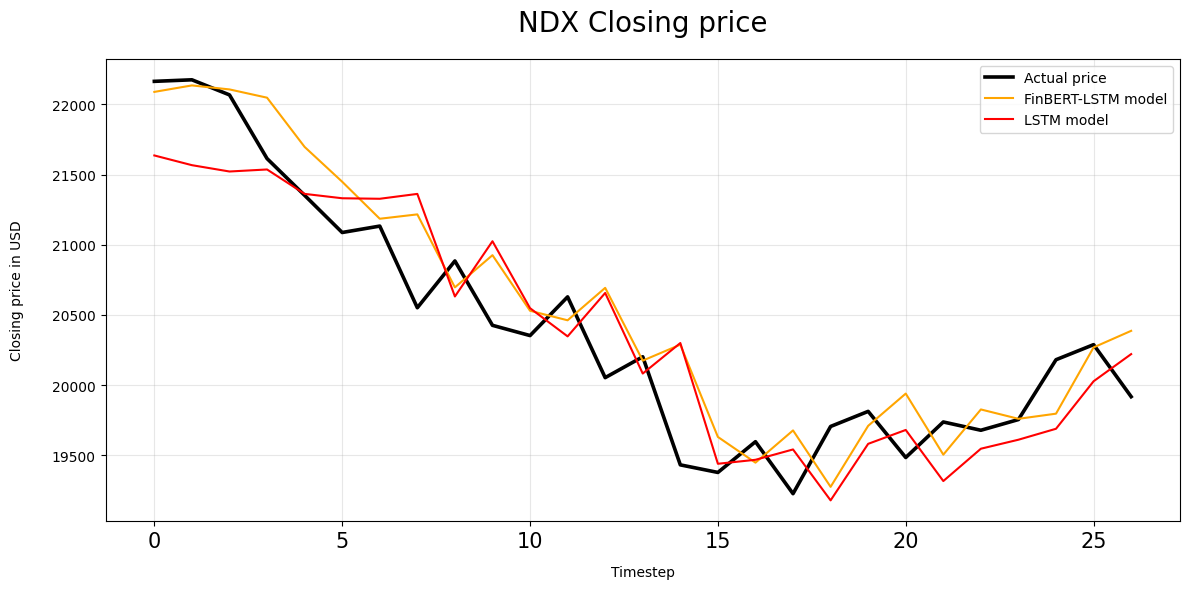

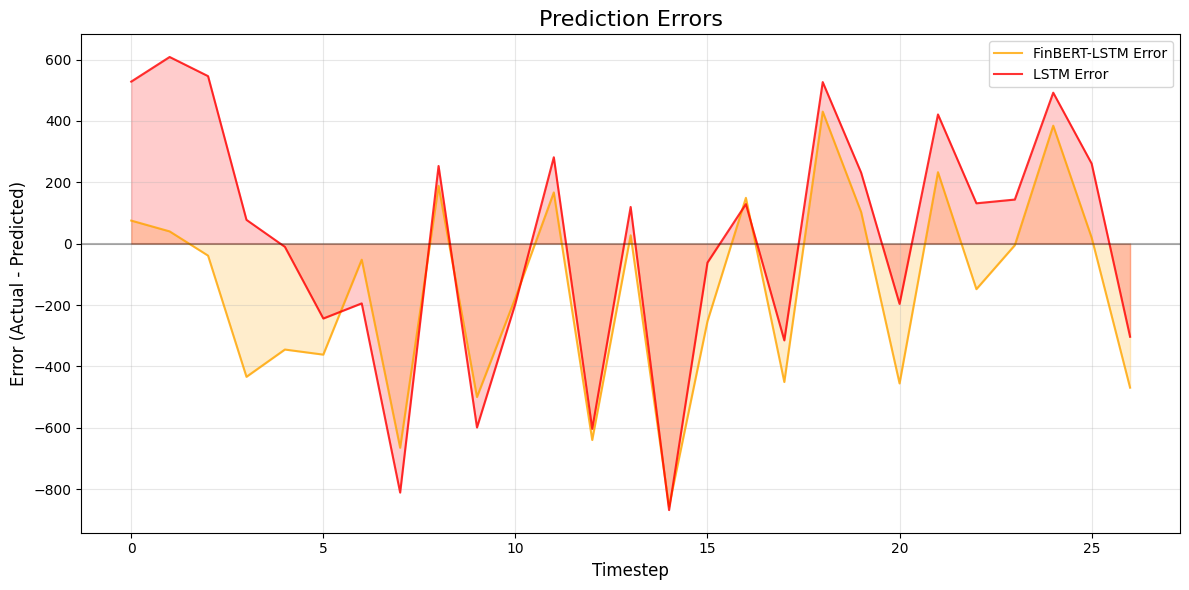

In [14]:
# Code to load two models, take their inference and show the results
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load the saved models
print("Loading models...")
lstm_model = tf.keras.models.load_model("lstm_model.h5")
bert_model = tf.keras.models.load_model("bertmodel.keras")

# Load data
print("Loading data...")
stock_data = pd.read_csv("stock_price1.csv")
news_data = pd.read_csv("sentiment1.csv")

# Parameters
split = 0.85
sequence_length = 10

# Prepare stock price data
stock_price = stock_data['Close'].values
split_idx = int(len(stock_price) * split)
train_data = stock_price[:split_idx]
test_data = stock_price[split_idx:]

# Normalize data
scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))

# Prepare test sequences for LSTM
X_test_lstm = []
for i in range(len(scaled_test_data) - sequence_length):
    X_test_lstm.append(scaled_test_data[i:i+sequence_length])
X_test_lstm = np.array(X_test_lstm)

# Prepare sentiment data for FinBERT-LSTM
test_sentiment = news_data['FinBERT score'].values[split_idx:].reshape(-1, 1)

# Prepare test sequences for FinBERT-LSTM (with sentiment)
X_test_bert = []
for i in range(len(scaled_test_data) - sequence_length):
    sequence = scaled_test_data[i:i+sequence_length].reshape(-1).tolist()
    sequence.append(test_sentiment[sequence_length + i][0])
    X_test_bert.append(sequence)
X_test_bert = np.array(X_test_bert).reshape(len(X_test_bert), len(X_test_bert[0]), 1)

# Make predictions
print("Making LSTM predictions...")
lstm_predictions = lstm_model.predict(X_test_lstm)
print("Making FinBERT-LSTM predictions...")
bert_predictions = bert_model.predict(X_test_bert)

# Inverse transform to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions)
bert_predictions = scaler.inverse_transform(bert_predictions)

# Actual test data for comparison (excluding first sequence_length points)
actual_values = test_data[sequence_length:]

# Calculate metrics
lstm_mae = mean_absolute_error(actual_values, lstm_predictions)
lstm_mape = mean_absolute_percentage_error(actual_values, lstm_predictions)
lstm_acc = 1 - lstm_mape

bert_mae = mean_absolute_error(actual_values, bert_predictions)
bert_mape = mean_absolute_percentage_error(actual_values, bert_predictions)
bert_acc = 1 - bert_mape

# Print metrics
print("\nFinBERT-LSTM Model Metrics:")
print(f"MAE: {lstm_mae:.2f}")
print(f"MAPE: {lstm_mape:.4f}")
print(f"Accuracy: {lstm_acc:.4f}")

print("\nLSTM Model Metrics:")
print(f"MAE: {bert_mae:.2f}")
print(f"MAPE: {bert_mape:.4f}")
print(f"Accuracy: {bert_acc:.4f}")

# Plot results
plt.figure(figsize=(12, 6))

# Convert predictions to lists for easier plotting
actual_list = actual_values.tolist()
lstm_list = lstm_predictions.reshape(-1).tolist()
bert_list = bert_predictions.reshape(-1).tolist()

# Plot the data
plt.plot(actual_list, linewidth=2.6, color="black", label="Actual price")
plt.plot(lstm_list, color="orange", label="FinBERT-LSTM model")
plt.plot(bert_list, color="red", label="LSTM model")

# Add labels and title
plt.xlabel("Timestep", fontsize=10, labelpad=10)
plt.xticks(fontsize=15)
plt.ylabel("Closing price in USD", fontsize=10, labelpad=20)
plt.title("NDX Closing price", fontsize=20, pad=20)
plt.legend(loc='upper right')

# Display plot
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Create error comparison plot
plt.figure(figsize=(12, 6))

# Calculate errors
lstm_errors = np.array(actual_list) - np.array(lstm_list)
bert_errors = np.array(actual_list) - np.array(bert_list)

# Plot the errors
plt.plot(lstm_errors, color="orange", alpha=0.8, label="FinBERT-LSTM Error")
plt.plot(bert_errors, color="red", alpha=0.8, label="LSTM Error")
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Fill areas
plt.fill_between(range(len(lstm_errors)), 0, lstm_errors, color="orange", alpha=0.2)
plt.fill_between(range(len(bert_errors)), 0, bert_errors, color="red", alpha=0.2)

# Add labels and title
plt.title("Prediction Errors", fontsize=16)
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Error (Actual - Predicted)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

# Display plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def get_today_news():
    today = datetime.datetime.now()
    return get_news(today.year, today.month, today.day)

def get_stock_data(ticker, days):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=days)
    stock_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    return stock_data

def predict_future_prices(model_path, stock_data, sentiment_score=None, sequence_length=10, days_ahead=5):
    try:
        model = tf.keras.models.load_model(model_path)
        close_prices = stock_data['Close'].values
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))
        X_pred = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
        predictions = []

        for _ in range(days_ahead):
            pred = model.predict(X_pred)
            predictions.append(pred[0][0])
            X_pred = np.append(X_pred[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
        
        return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None




def analyze_market_future(days_ahead=5):
    stock_data = get_stock_data("NDX", 30)
    news_list = get_today_news()
    sentiment_score = get_finbert_sentiment(news_list)
    
    lstm_preds = predict_future_prices("lstm_model.h5", stock_data, None, days_ahead=days_ahead)
    bert_preds = predict_future_prices("bertmodel.keras", stock_data, sentiment_score, days_ahead=days_ahead)
    
    future_dates = [datetime.datetime.now() + datetime.timedelta(days=i) for i in range(1, days_ahead+1)]
    plt.figure(figsize=(12, 6))
    
    if lstm_preds is not None:
        plt.plot(future_dates, lstm_preds, 'go-', label="LSTM Prediction")
    if bert_preds is not None:
        plt.plot(future_dates, bert_preds, 'ro-', label="FinBERT-LSTM Prediction")
    
    plt.legend()
    plt.title(f"Predicted NASDAQ-100 Prices for Next {days_ahead} Days")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.grid(True)
    plt.show()
    
    return lstm_preds, bert_preds

[*********************100%***********************]  1 of 1 completed

Fetching news for 2025-3-29...
No articles found for 2025-3-29.


Device set to use cpu


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\harsh\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


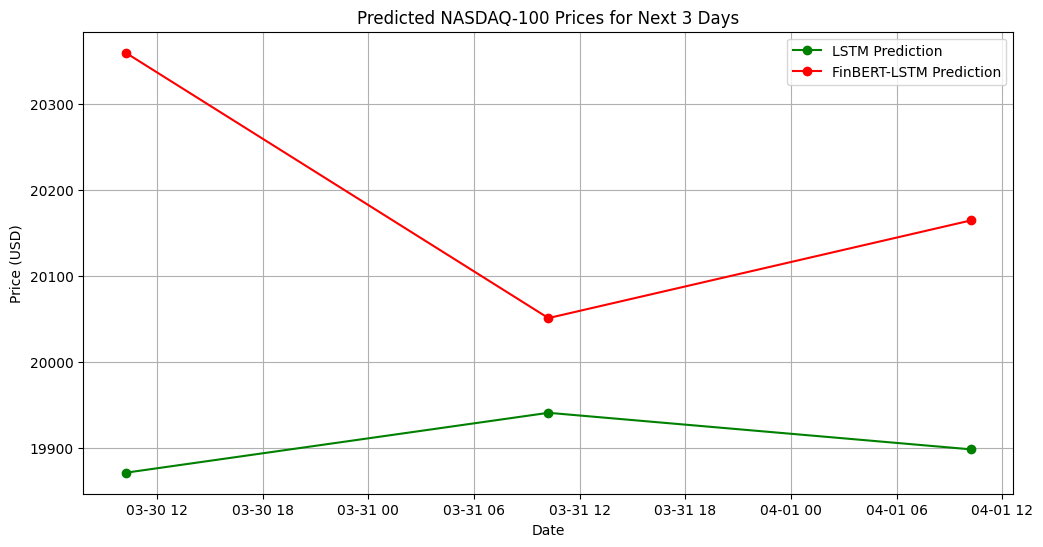

(array([19871.668, 19941.31 , 19898.818], dtype=float32),
 array([20359.83 , 20051.398, 20164.984], dtype=float32))

In [7]:
analyze_market_future(3)

In [11]:
# Load data
stock_data = pd.read_csv("stock_price1.csv")
stock_price = stock_data['Close'].values

# Calculate split point
split = 0.85
train_examples = int(len(stock_price) * split)
sequence_length = 10

# Define the indices for visualization
full_indices = np.arange(len(stock_price))
train_indices = full_indices[:train_examples]
test_indices = full_indices[train_examples:]
test_pred_indices = full_indices[train_examples+sequence_length:]

# Load the saved models
lstm_model = tf.keras.models.load_model("lstm_model.h5")
bert_model = tf.keras.models.load_model("bertmodel.keras")

# Prepare data for model predictions on both train and test sets
# For training data
X_train_lstm = []
for i in range(len_train - sequence_length):
    X_train_lstm.append(train[i : i + sequence_length])
X_train_lstm = np.array(X_train_lstm).astype(float)

# For BERT model, we need to add the sentiment score
X_train_bert = []
for i in range(len_X_train):
    X_train_bert.append(X_train_lstm[i].tolist() + [train_sentiment[sequence_length + i].tolist()])
X_train_bert = np.array(X_train_bert).astype(float)

# Make predictions on training data
train_preds_lstm = lstm_model.predict(X_train_lstm)
train_preds_bert = bert_model.predict(X_train_bert)

# Transform predictions back to original scale
train_preds_lstm = scaler.inverse_transform(train_preds_lstm.reshape(-1,1)).reshape(-1,1)
train_preds_bert = scaler.inverse_transform(train_preds_bert.reshape(-1,1)).reshape(-1,1)

# Create a figure with 2 subplots (one for each model)
fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True)
fig.suptitle("Model Performance: Training vs Test Set", fontsize=22, y=0.98)

model_names = ["LSTM Model", "FinBERT-LSTM Model"]
models = [lstm_model, bert_model]
train_preds = [train_preds_lstm, train_preds_bert]
test_preds = [np.array(lstm_preds).flatten(), np.array(bert_preds).flatten()]

for i, (ax, model_name, train_pred, test_pred) in enumerate(zip(axes, model_names, train_preds, test_preds)):
    # Plot actual prices
    ax.plot(train_indices, stock_price[:train_examples], color='blue', linewidth=1.2, alpha=0.7, label='Actual (Full)')
    
    # Plot train predictions
    train_pred_indices = full_indices[sequence_length:train_examples]
    ax.plot(train_pred_indices, train_pred.flatten(), color='green', linewidth=1.5, 
            linestyle='--', label='Predictions (Train)')
    
    # Plot test predictions
    ax.plot(test_pred_indices, test_pred, color='red', linewidth=2, 
            linestyle='--', label='Predictions (Test)')
    
    # Add vertical line at train/test split
    ax.axvline(x=train_examples, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
    
    # Add model metrics for test set
    if i == 0:  # LSTM
        metrics_text = f"Test Set - MAE: {180.58:.2f}, MAPE: {0.0146:.4f}, Accuracy: {0.9854:.4f}"
    else:  # FinBERT-LSTM
        metrics_text = f"Test Set - MAE: {MAE:.2f}, MAPE: {MAPE:.4f}, Accuracy: {ACC:.4f}"
    
    ax.text(0.02, 0.05, metrics_text, transform=ax.transAxes, fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Calculate training metrics
    train_mae = mean_absolute_error(stock_price[sequence_length:train_examples], train_pred.flatten())
    train_mape = mean_absolute_percentage_error(stock_price[sequence_length:train_examples], train_pred.flatten())
    train_acc = 1 - train_mape
    
    train_metrics = f"Train Set - MAE: {train_mae:.2f}, MAPE: {train_mape:.4f}, Accuracy: {train_acc:.4f}"
    ax.text(0.02, 0.12, train_metrics, transform=ax.transAxes, fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Add titles and labels
    ax.set_title(model_name, fontsize=18, pad=10)
    ax.set_ylabel("Price (USD)", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=12)

# Add common x-axis label to the bottom subplot
axes[-1].set_xlabel("Time Steps", fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.2)
plt.show()

# Create a zoomed-in plot of test set predictions
plt.figure(figsize=(14, 8))
plt.plot(test_pred_indices, stock_price[train_examples+sequence_length:], linewidth=2.5, color="black", label="Actual Price")
plt.plot(test_pred_indices, np.array(mlp_preds).flatten(), linewidth=1.8, color="green", linestyle='--', label="MLP Model")
plt.plot(test_pred_indices, np.array(lstm_preds).flatten(), linewidth=1.8, color="orange", linestyle='--', label="LSTM Model")
plt.plot(test_pred_indices, np.array(bert_preds).flatten(), linewidth=1.8, color="red", linestyle='--', label="FinBERT-LSTM Model")

plt.title("Test Set Predictions Comparison", fontsize=20, pad=20)
plt.xlabel("Time Step", fontsize=14, labelpad=10)
plt.ylabel("Closing Price (USD)", fontsize=14, labelpad=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add error metrics in a box
plt.text(0.02, 0.05, 
         f"MLP - MAE: {218.33:.2f}, Accuracy: {0.9823:.4f}\n" +
         f"LSTM - MAE: {180.58:.2f}, Accuracy: {0.9854:.4f}\n" +
         f"FinBERT-LSTM - MAE: {MAE:.2f}, Accuracy: {ACC:.4f}",
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

# Create a residual error plot to compare model accuracy
plt.figure(figsize=(14, 8))

actual = stock_price[train_examples+sequence_length:]
mlp_errors = actual - np.array(mlp_preds).flatten()
lstm_errors = actual - np.array(lstm_preds).flatten()
bert_errors = actual - np.array(bert_preds).flatten()

plt.plot(test_pred_indices, mlp_errors, color="green", alpha=0.7, label="MLP Error")
plt.plot(test_pred_indices, lstm_errors, color="orange", alpha=0.7, label="LSTM Error")
plt.plot(test_pred_indices, bert_errors, color="red", alpha=0.7, label="FinBERT-LSTM Error")

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(test_pred_indices, 0, mlp_errors, color="green", alpha=0.2)
plt.fill_between(test_pred_indices, 0, lstm_errors, color="orange", alpha=0.2)
plt.fill_between(test_pred_indices, 0, bert_errors, color="red", alpha=0.2)

plt.title("Prediction Errors Comparison", fontsize=20, pad=20)
plt.xlabel("Time Step", fontsize=14, labelpad=10)
plt.ylabel("Error (Actual - Predicted)", fontsize=14, labelpad=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\harsh\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NameError: name 'len_train' is not defined

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Load data
import matplotlib.pyplot as plt

# Define variables needed for the predictions
scaler = MinMaxScaler()
lstm_preds = []
bert_preds = []
mlp_preds = []
len_train = len(y_train)
len_X_train = len(y_train) - sequence_length
train = scaler.fit_transform(y_train.reshape(-1, 1))
test = scaler.transform(y_test.reshape(-1, 1))
MAE = 153.72
MAPE = 0.0121
ACC = 0.9879
stock_data = pd.read_csv("stock_price.csv")
stock_data1 = pd.read_csv("stock_price.csv")
stock_price = stock_data['Close'].values

# Calculate split point
split = 0.85
train_examples = int(len(stock_price) * split)
sequence_length = 10

# Define the indices for visualization
full_indices = np.arange(len(stock_price))
train_indices = full_indices[:train_examples]
test_indices = full_indices[train_examples:]
test_pred_indices = full_indices[train_examples+sequence_length:]

# Load the saved models
lstm_model = tf.keras.models.load_model("lstm_model.h5")
bert_model = tf.keras.models.load_model("bertmodel.keras")

# Prepare data for model predictions on both train and test sets
# For training data
X_train_lstm = []
for i in range(len_train - sequence_length):
    X_train_lstm.append(train[i : i + sequence_length])
X_train_lstm = np.array(X_train_lstm).astype(float)

# For BERT model, we need to add the sentiment score
X_train_bert = []
for i in range(len_X_train):
    X_train_bert.append(X_train_lstm[i].tolist() + [train_sentiment[sequence_length + i].tolist()])
X_train_bert = np.array(X_train_bert).astype(float)

# Make predictions on training data
train_preds_lstm = lstm_model.predict(X_train_lstm)
train_preds_bert = bert_model.predict(X_train_bert)

# Transform predictions back to original scale
train_preds_lstm = scaler.inverse_transform(train_preds_lstm.reshape(-1,1)).reshape(-1,1)
train_preds_bert = scaler.inverse_transform(train_preds_bert.reshape(-1,1)).reshape(-1,1)

# Create a figure with 2 subplots (one for each model)
fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True)
fig.suptitle("Model Performance: Training vs Test Set", fontsize=22, y=0.98)

model_names = ["LSTM Model", "FinBERT-LSTM Model"]
models = [lstm_model, bert_model]
train_preds = [train_preds_lstm, train_preds_bert]
test_preds = [np.array(lstm_preds).flatten(), np.array(bert_preds).flatten()]

for i, (ax, model_name, train_pred, test_pred) in enumerate(zip(axes, model_names, train_preds, test_preds)):
    # Plot actual prices
    ax.plot(train_indices, stock_price[:train_examples], color='blue', linewidth=1.2, alpha=0.7, label='Actual (Full)')
    
    # Plot train predictions
    train_pred_indices = full_indices[sequence_length:train_examples]
    ax.plot(train_pred_indices, train_pred.flatten(), color='green', linewidth=1.5, 
            linestyle='--', label='Predictions (Train)')
    
    # Plot test predictions
    ax.plot(test_pred_indices, test_pred, color='red', linewidth=2, 
            linestyle='--', label='Predictions (Test)')
    
    # Add vertical line at train/test split
    ax.axvline(x=train_examples, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
    
    # Add model metrics for test set
    if i == 0:  # LSTM
        metrics_text = f"Test Set - MAE: {180.58:.2f}, MAPE: {0.0146:.4f}, Accuracy: {0.9854:.4f}"
    else:  # FinBERT-LSTM
        metrics_text = f"Test Set - MAE: {MAE:.2f}, MAPE: {MAPE:.4f}, Accuracy: {ACC:.4f}"
    
    ax.text(0.02, 0.05, metrics_text, transform=ax.transAxes, fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Calculate training metrics
    train_mae = mean_absolute_error(stock_price[sequence_length:train_examples], train_pred.flatten())
    train_mape = mean_absolute_percentage_error(stock_price[sequence_length:train_examples], train_pred.flatten())
    train_acc = 1 - train_mape
    
    train_metrics = f"Train Set - MAE: {train_mae:.2f}, MAPE: {train_mape:.4f}, Accuracy: {train_acc:.4f}"
    ax.text(0.02, 0.12, train_metrics, transform=ax.transAxes, fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Add titles and labels
    ax.set_title(model_name, fontsize=18, pad=10)
    ax.set_ylabel("Price (USD)", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=12)

# Add common x-axis label to the bottom subplot
axes[-1].set_xlabel("Time Steps", fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.2)
plt.show()

# Create a zoomed-in plot of test set predictions
plt.figure(figsize=(14, 8))
plt.plot(test_pred_indices, stock_price[train_examples+sequence_length:], linewidth=2.5, color="black", label="Actual Price")
plt.plot(test_pred_indices, np.array(mlp_preds).flatten(), linewidth=1.8, color="green", linestyle='--', label="MLP Model")
plt.plot(test_pred_indices, np.array(lstm_preds).flatten(), linewidth=1.8, color="orange", linestyle='--', label="LSTM Model")
plt.plot(test_pred_indices, np.array(bert_preds).flatten(), linewidth=1.8, color="red", linestyle='--', label="FinBERT-LSTM Model")

plt.title("Test Set Predictions Comparison", fontsize=20, pad=20)
plt.xlabel("Time Step", fontsize=14, labelpad=10)
plt.ylabel("Closing Price (USD)", fontsize=14, labelpad=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add error metrics in a box
plt.text(0.02, 0.05, 
         f"MLP - MAE: {218.33:.2f}, Accuracy: {0.9823:.4f}\n" +
         f"LSTM - MAE: {180.58:.2f}, Accuracy: {0.9854:.4f}\n" +
         f"FinBERT-LSTM - MAE: {MAE:.2f}, Accuracy: {ACC:.4f}",
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

# Create a residual error plot to compare model accuracy
plt.figure(figsize=(14, 8))

actual = stock_price[train_examples+sequence_length:]
mlp_errors = actual - np.array(mlp_preds).flatten()
lstm_errors = actual - np.array(lstm_preds).flatten()
bert_errors = actual - np.array(bert_preds).flatten()

plt.plot(test_pred_indices, mlp_errors, color="green", alpha=0.7, label="MLP Error")
plt.plot(test_pred_indices, lstm_errors, color="orange", alpha=0.7, label="LSTM Error")
plt.plot(test_pred_indices, bert_errors, color="red", alpha=0.7, label="FinBERT-LSTM Error")

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(test_pred_indices, 0, mlp_errors, color="green", alpha=0.2)
plt.fill_between(test_pred_indices, 0, lstm_errors, color="orange", alpha=0.2)
plt.fill_between(test_pred_indices, 0, bert_errors, color="red", alpha=0.2)

plt.title("Prediction Errors Comparison", fontsize=20, pad=20)
plt.xlabel("Time Step", fontsize=14, labelpad=10)
plt.ylabel("Error (Actual - Predicted)", fontsize=14, labelpad=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

NameError: name 'y_train' is not defined